<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import seaborn as sns
import pandas as pd
import pcmdpy as ppy
from astropy.io import fits
from scipy.stats import poisson
from astropy.visualization import make_lupton_rgb
%matplotlib inline

GPU acceleration not available, sorry
No module named 'pycuda'


In [2]:
results = {}
results['arm2'] = ppy.plotting.ResultsPlotter('../pcmdpy/aws/results/m51_arm2_twostage_v11_init.csv')

In [3]:
r = results['arm2']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x110a43c50>,
      dtype=object)

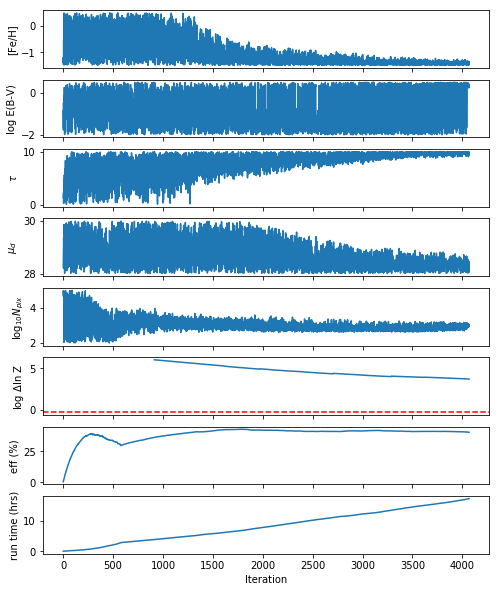

In [4]:
r.plot_chains()

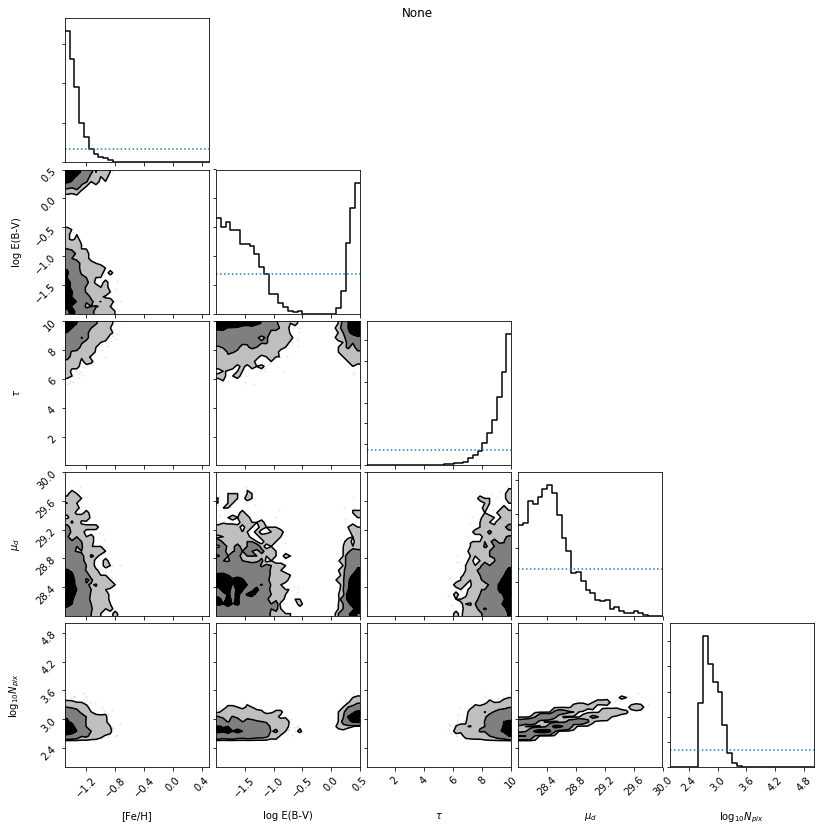

In [5]:
r.plot_corner(burn=2000);

In [6]:
r.params

['logfeh_mean', 'logdust_med', 'tau', 'dmod', 'logNpix']

In [7]:
[r.df[p].values[-1] for p in r.params]

[-1.4656, 0.3017, 9.366, 28.436999999999998, 3.0482]

In [8]:
r.df.logl.values[-1]

-233790.0

In [24]:
f = ppy.instrument.default_m51_filters()

In [27]:
for filt in f:
    filt._exposure /= 4.  # Exposure is miscalculated in FITS files

In [10]:
%%time
iso_model = ppy.isochrones.Isochrone_Model(f)

CPU times: user 10.7 s, sys: 1.88 s, total: 12.5 s
Wall time: 12.6 s


In [28]:
%%time
iso_model = ppy.isochrones.Isochrone_Model(f, dm_interp=0.15)

starting manual interpolation
done with interpolation
CPU times: user 35.2 s, sys: 8.22 s, total: 43.5 s
Wall time: 45.1 s


In [29]:
driv = ppy.driver.Driver(iso_model, gpu=False)

In [13]:
g = ppy.galaxy.TauFull(np.array([-1.4656, 0.302, 3.0482, 9.366, 28.44]))

In [53]:
g2 = ppy.galaxy.TauFull(np.array([0., -1., 3.4, 10., 29.67]))

In [31]:
shot_noise = np.array([84., 41., 54.]) / 4.

In [32]:
%%time
pcmd, _ = driv.simulate(g, 128, sky_noise=shot_noise, fixed_seed=True, downsample=5, shot_noise=True)

CPU times: user 1min 28s, sys: 9.6 s, total: 1min 37s
Wall time: 1min 43s


In [54]:
%%time
pcmd2, _ = driv.simulate(g2, 256, sky_noise=shot_noise, fixed_seed=True, downsample=5, shot_noise=True)

CPU times: user 6min 25s, sys: 1min 3s, total: 7min 28s
Wall time: 8min 27s


In [34]:
pcmd_data = np.loadtxt('../data/m51_arm2_I-VI-BV.dat', unpack=True)

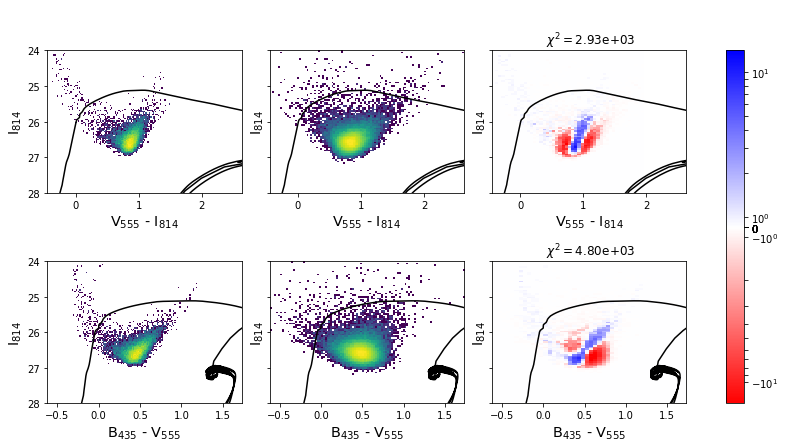

In [35]:
fig, axes = plt.subplots(ncols=3, nrows=2, sharey=True, sharex='row', figsize=(12,6))
ppy.plotting.plot_pcmd(pcmd[:2], ax=axes[0,0]);
ppy.plotting.plot_pcmd(pcmd_data[:2], ax=axes[0,1]);
ppy.plotting.plot_pcmd_residual(pcmd[:2], pcmd_data[:2], ax=axes[0,2], bins=[np.arange(-1., 2., 0.05), np.arange(24, 28, 0.05)]);
ppy.plotting.plot_pcmd(pcmd[::2], ax=axes[1,0]);
ppy.plotting.plot_pcmd(pcmd_data[::2], ax=axes[1,1]);
ppy.plotting.plot_pcmd_residual(pcmd[::2], pcmd_data[::2], ax=axes[1,2], bins=[np.arange(-1., 2., 0.05), np.arange(24, 28, 0.05)]);
ppy.plotting.plot_isochrone(iso_model, axes=axes[:,0]);
ppy.plotting.plot_isochrone(iso_model, axes=axes[:,1]);
ppy.plotting.plot_isochrone(iso_model, axes=axes[:,2]);
axes[0,0].set_ylim([28., 24.])
plt.tight_layout()
plt.colorbar(ax=axes)

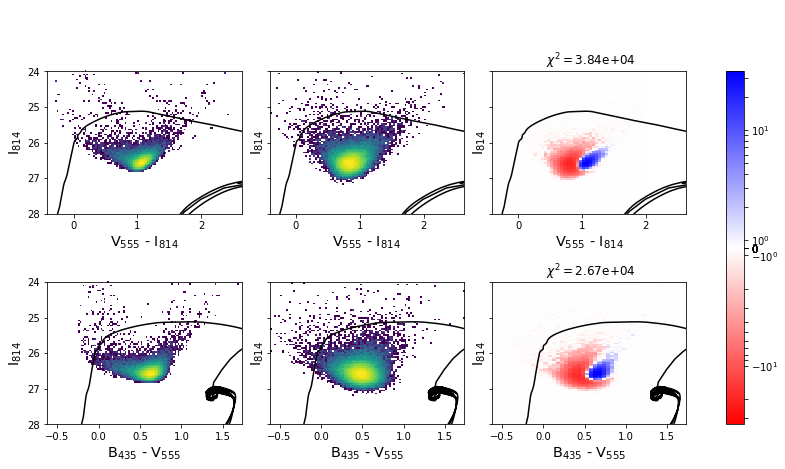

In [55]:
fig, axes = plt.subplots(ncols=3, nrows=2, sharey=True, sharex='row', figsize=(12,6))
ppy.plotting.plot_pcmd(pcmd2[:2], ax=axes[0,0]);
ppy.plotting.plot_pcmd(pcmd_data[:2], ax=axes[0,1]);
ppy.plotting.plot_pcmd_residual(pcmd2[:2], pcmd_data[:2], ax=axes[0,2], bins=[np.arange(-1., 2., 0.05), np.arange(24, 28, 0.05)]);
ppy.plotting.plot_pcmd(pcmd2[::2], ax=axes[1,0]);
ppy.plotting.plot_pcmd(pcmd_data[::2], ax=axes[1,1]);
ppy.plotting.plot_pcmd_residual(pcmd2[::2], pcmd_data[::2], ax=axes[1,2], bins=[np.arange(-1., 2., 0.05), np.arange(24, 28, 0.05)]);
ppy.plotting.plot_isochrone(iso_model, axes=axes[:,0]);
ppy.plotting.plot_isochrone(iso_model, axes=axes[:,1]);
ppy.plotting.plot_isochrone(iso_model, axes=axes[:,2]);
axes[0,0].set_ylim([28., 24.])
plt.tight_layout()
plt.colorbar(ax=axes)

In [2]:
sns.set_context('poster')

In [3]:
files = ['../data/h_m51_i_s05_drz_sci.fits', '../data/h_m51_v_s05_drz_sci.fits', '../data/h_m51_b_s05_drz_sci.fits']
filts = ppy.instrument.m51_filters
m51 = ppy.utils.DataSet(files, filts)
for f in m51.filters:
    f._exposure /= 6.  # Exposure is miscalculated in FITS files

In [4]:
f1 = m51.filters

In [37]:
def read_region(ds9_line):
    try:
        data, comments = ds9_line.split(' #')
    except ValueError:
        return None, None, None
    if not data.startswith('box'):
        return None, None, None
    x, y, dx, dy, _ = [float(s) for s in data.lstrip('box(').rstrip(')').split(',')]
    xlim = [x-dx/2, x+dx/2]
    ylim = [y-dy/2, y+dy/2]
    if 'text=' in comments:
        name = comments.split('text={')[-1].split('}')[0]
    else:
        name = ''
    return xlim, ylim, name

In [48]:
regions = {}
with open('../data/m51_regions_detector.reg', 'r') as f:
    lines = f.readlines()
    for line in lines:
        xlim, ylim, name = read_region(line)
        if name is not None:
            regions[name.lower()] = (xlim, ylim)

In [49]:
def add_region(xlim, ylim, ax, title=None, **kwargs):
    dx = np.diff(xlim)[0]
    dy = np.diff(ylim)[0]
    kwargs['color'] = kwargs.get('color', 'r')
    kwargs['lw'] = kwargs.get('lw', 2)
    kwargs['fill'] = kwargs.get('fill', False)
    r = ax.add_patch(mpl.patches.Rectangle((xlim[0], ylim[0]), dx, dy, **kwargs))
    if title is not None:
        ax.text(xlim[0], ylim[1]+0.1*dy, title, color=kwargs['color'],
                verticalalignment='bottom', horizontalalignment='left', fontsize=16)
    return r

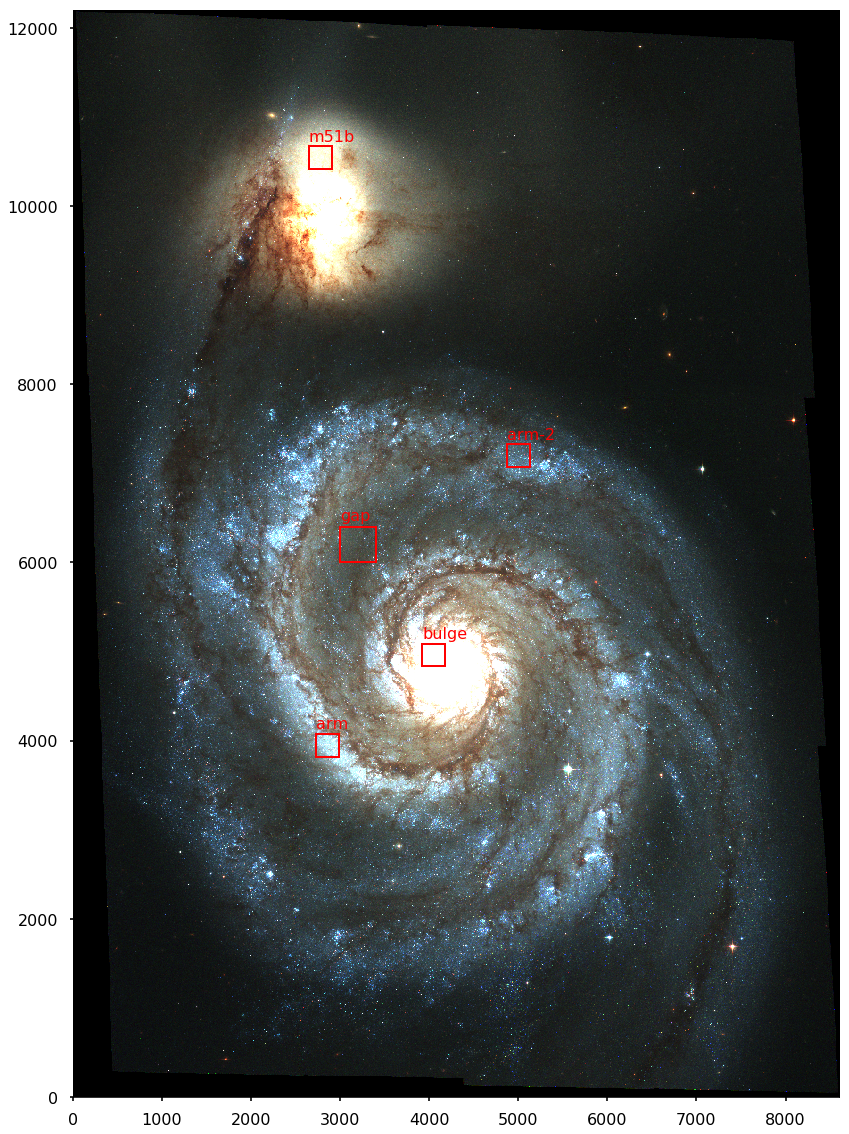

In [50]:
fig, ax = plt.subplots(figsize=(15, 20))
ims, extent = m51.get_image(downsample=10)
_ = ppy.plotting.plot_rgb_image(ims, extent=extent, ax=ax)
for r, (xlim, ylim) in regions.items():
    add_region(xlim, ylim, ax, title=r)

In [51]:
try:
    ppy.gpu_utils.initialize_gpu(n=0)
    GPU_AVAIL = True
except:
    GPU_AVAIL = False

In [52]:
try:
    iso_model
except NameError:
    iso_model = ppy.isochrones.Isochrone_Model(f1)
driv = ppy.driver.Driver(iso_model, gpu=GPU_AVAIL)

In [53]:
X, Y = np.meshgrid(np.arange(m51.im_shape[1]), np.arange(m51.im_shape[0]))

In [54]:
def make_bools(xlim, ylim):
    return (xlim[0] <= X) & (X < xlim[1]) & (ylim[0] <= Y) & (Y < ylim[1])

In [56]:
bools = {}
for k, (xlim, ylim) in regions.items():
    bools[k] = make_bools(xlim, ylim)

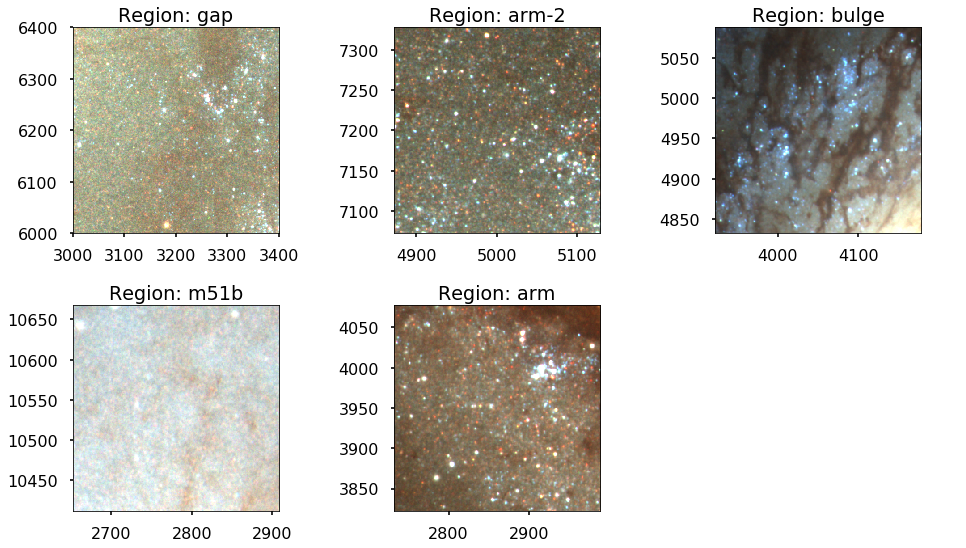

In [65]:
ims = {}
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(14, 8))
for k, ax in zip(bools.keys(), axes.flatten()):
    ims[k], extent = m51.get_image(bools[k], downsample=1)
    ax = ppy.plotting.plot_rgb_image(ims[k], extent=extent, ax=ax, clip_percent=99.)
    ax.set_title('Region: {:s}'.format(k))
axes[1,2].axis('off')
plt.tight_layout()

In [70]:
dmod_m51 = 25. + 5.*np.log10(8.58)

In [66]:
pcmds = {}
for k, b in bools.items():
    pcmds[k] = m51.get_pcmd(b)

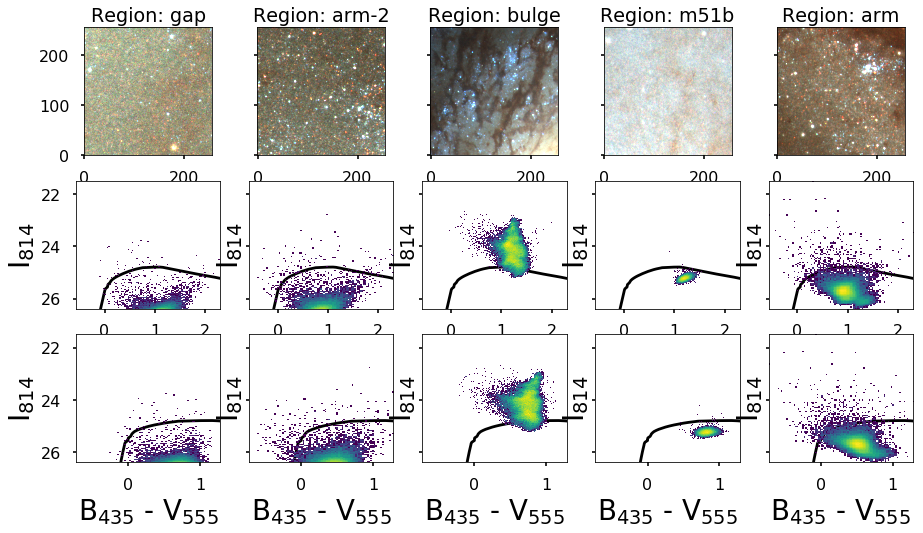

In [73]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 8), sharex='row', sharey='row')
for i, k in enumerate(pcmds.keys()):
    ppy.plotting.plot_rgb_image(ims[k], ax=axes[0,i], clip_percent=99.)
    ppy.plotting.plot_pcmd(pcmds[k][:2], bins=100, ax=axes[1,i])
    ppy.plotting.plot_pcmd(pcmds[k][::2], bins=100, ax=axes[2,i])
    ppy.plotting.plot_isochrone(iso_model, dmod=dmod_m51, axes=axes[1:, i], zorder=-1)
    axes[0,i].set_title('Region: {:s}'.format(k))

In [46]:

ssp = ppy.galaxy.DefaultSSP(np.array([-0., -.5, 3., 10.]), dmod=dmod_m51)
gal = ppy.galaxy.LogNormTau(dmod=dmod_m51)
gal.sfh_model = gal.sfh_model.as_default()
gal.set_params(np.array([0., -.5, 1.0, 3.5, 4.]))

In [26]:
sky = np.array([82, 41, 55])
one_sig = np.array([f.counts_to_mag(poisson.ppf(0.84, s)) for f,s in zip(f1,sky)])
three_sig = np.array([f.counts_to_mag(poisson.ppf(0.9985, s)) for f,s in zip(f1,sky)])
signal_gap = np.array([544, 204, 272])
signal_arm = np.array([1360, 680, 816])
blank_gap = np.array([f.counts_to_mag(s) for f,s in zip(f1, signal_gap)])
mean_gap = np.array([f.counts_to_mag(s) for f,s in zip(f1, signal_gap + sky)])
one_gap = np.array([f.counts_to_mag(s) for f,s in zip(f1, signal_gap + one_sig)])
three_gap = np.array([f.counts_to_mag(s) for f,s in zip(f1, signal_gap + three_sig)])
blank_arm = np.array([f.counts_to_mag(s) for f,s in zip(f1, signal_arm)])
mean_arm = np.array([f.counts_to_mag(s) for f,s in zip(f1, signal_arm + sky)])
one_arm = np.array([f.counts_to_mag(s) for f,s in zip(f1, signal_arm + one_sig)])
three_arm = np.array([f.counts_to_mag(s) for f,s in zip(f1, signal_arm + three_sig)])
sky_sig = np.std(sky)
sky_mags = np.array([f.counts_to_mag(s) for f,s in zip(f1, sky)])

In [53]:
%%time
pcmd_test, ims_test = driv.simulate(gal, 400, downsample=5, psf=True, sky_noise=sky*3., shot_noise=True)

CPU times: user 54.7 s, sys: 5.11 s, total: 59.8 s
Wall time: 1min


In [23]:
bins = [np.linspace(-1, 3,100), np.linspace(20., 30., 100)]
# bins=100

In [24]:
sky_mags

array([28.57761264, 29.53368763, 30.02401554])

In [52]:
x = ims_gap[:,:,0].min()
f1[0].counts_to_mag(x), f1[0].counts_to_mag(x - 82), 

(27.054347381678774, 27.360722346198408)

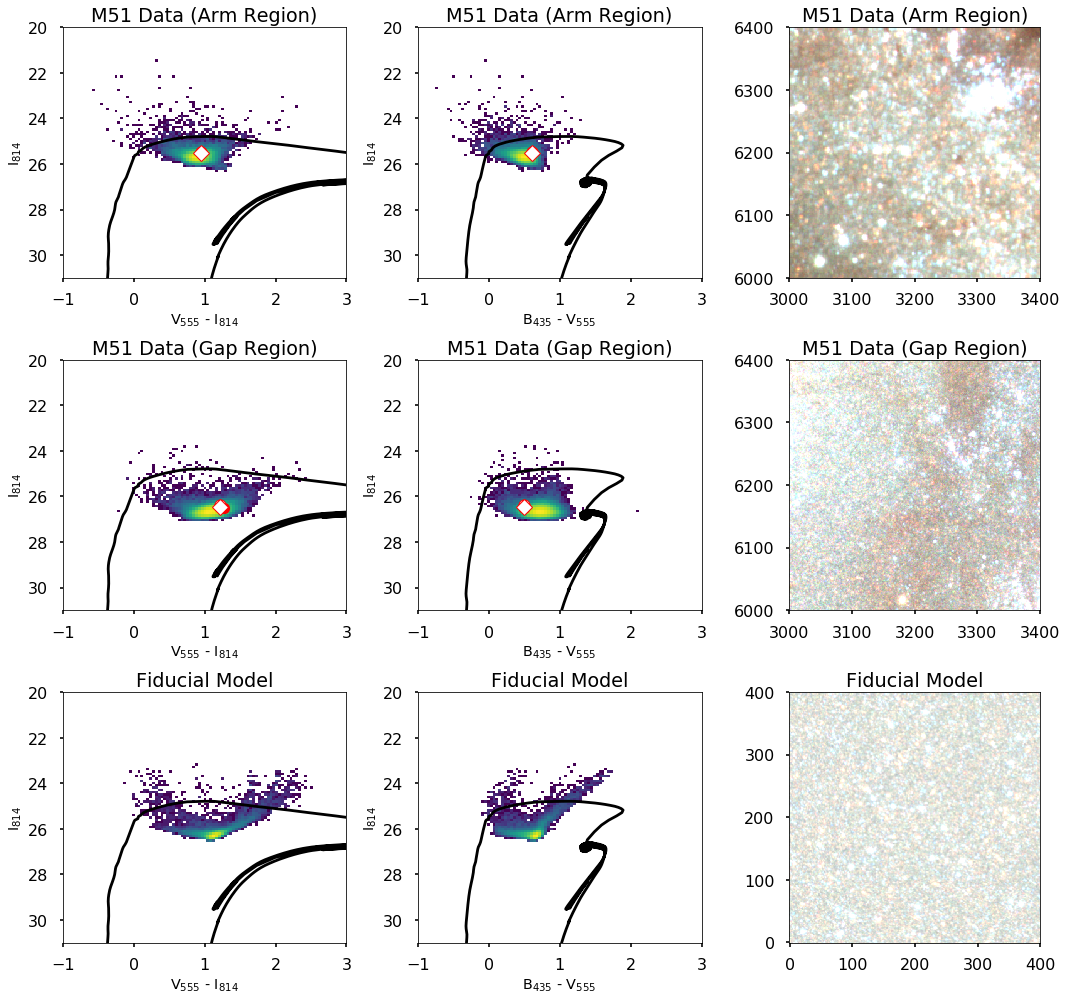

In [54]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(15, 14))
axes[0,0].hist2d(pcmd_arm[1], pcmd_arm[0], bins=bins, norm=mpl.colors.LogNorm())
axes[0,1].hist2d(pcmd_arm[2], pcmd_arm[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,0].hist2d(pcmd_gap[1], pcmd_gap[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,1].hist2d(pcmd_gap[2], pcmd_gap[0], bins=bins, norm=mpl.colors.LogNorm())
axes[2,0].hist2d(pcmd_test[1], pcmd_test[0], bins=bins, norm=mpl.colors.LogNorm())
axes[2,1].hist2d(pcmd_test[2], pcmd_test[0], bins=bins, norm=mpl.colors.LogNorm())
for a in axes[0]:
    a.set_title('M51 Data (Arm Region)')
for a in axes[1]:
    a.set_title('M51 Data (Gap Region)')
for a in axes[2]:
    a.set_title('Fiducial Model')
ppy.plotting.plot_rgb_image(ims_arm, extent=extent, ax=axes[0,2], clip_percent=90.)
ppy.plotting.plot_rgb_image(ims_gap, extent=extent, ax=axes[1,2], clip_percent=90.)
ppy.plotting.plot_rgb_image(ims_test, ax=axes[2,2], clip_percent=90.)
ppy.plotting.plot_isochrone(iso_model, dmod=dmod_m51, gal_model=ssp, axes=axes[0,:2], system='vega')
ppy.plotting.plot_isochrone(iso_model, dmod=dmod_m51, gal_model=ssp, axes=axes[1,:2], system='vega')
ppy.plotting.plot_isochrone(iso_model, dmod=dmod_m51, gal_model=ssp, axes=axes[2,:2], system='vega')
for i in range(2):
    a = axes[0, i]
    a.plot(blank_arm[i+1] - blank_arm[i], blank_arm[0], 'ro', label='No Sky')
    a.plot(mean_arm[i+1] - mean_arm[i], mean_arm[0], 'ro', mfc='w', mec='r', mew=1, label='Mean Sky')
    a.plot(mean_arm[i+1] - mean_arm[i], three_arm[0], 'rD', mfc='w', mec='r', mew=1, label='Mean Sky')
#     a.plot(mean_arm[i+1] - three_arm[i], three_arm[0], 'rD', mfc='w', mec='r', mew=1, label='Mean Sky')
    a = axes[1, i]
    a.plot(blank_gap[i+1] - blank_gap[i], blank_gap[0], 'ro', label='No Sky')
    a.plot(mean_gap[i+1] - mean_gap[i], mean_gap[0], 'ro', mfc='w', mec='r', mew=1, label='Mean Sky')
    a.plot(mean_gap[i+1] - mean_gap[i], three_gap[0], 'rD', mfc='w', mec='r', mew=1, label='Mean Sky')
#     a.plot(mean_gap[i+1] - three_gap[i], three_gap[0], 'rD', mfc='w', mec='r', mew=1, label='Mean Sky')
plt.tight_layout()
for a in axes[:, :2].flatten():
    a.set_ylim(ymin=31.)
# plt.savefig('figures/m51_test.pdf')

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
axes[0,0].hist2d(pcmd_gap[1], pcmd_gap[0], bins=bins, norm=mpl.colors.LogNorm())
axes[0,1].hist2d(pcmd_gap[2], pcmd_gap[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,0].hist2d(pcmd_test[1], pcmd_test[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,1].hist2d(pcmd_test[2], pcmd_test[0], bins=bins, norm=mpl.colors.LogNorm())
for a in axes[0,:2]:
    a.set_title('M51 Data (Gap Region)')
for a in axes[1,:2]:
    a.set_title('Fiducial Model')
ppy.plotting.plot_rgb_image(ims_gap, extent=extent, ax=axes[0,2])
ppy.plotting.plot_rgb_image(ims_test, ax=axes[1,2])
iso_model.plot_isochrone(ssp, axes=axes[0,:2], system='vega')
iso_model.plot_isochrone(ssp, axes=axes[1,:2], system='vega')
plt.tight_layout()
# plt.savefig('figures/m51_test.pdf')

In [27]:
# base_info = 'Vega Mags\nDisk Gap region extracted from square X=[3000,3400), Y=[6000, 6400) from M51 image'
# np.savetxt('../data/m51_gap_I-VI-BV.dat', pcmd_data.T, fmt='%.6f', header='Imag Vmag-Imag Bmag-Vmag\nF814W F555W-F814W F435W-F555W\n'+base_info)
# np.savetxt('../data/m51_gap_I-BV.dat', pcmd_data[::2].T, fmt='%.6f', header='Imag Bmag-Vmag\nF814W F435W-F555W\n'+base_info)
# np.savetxt('../data/m51_gap_I-VI.dat', pcmd_data[:2].T, fmt='%.6f', header='Imag Bmag-Vmag\nF814W F555W-F814W\n'+base_info)

In [17]:
base_info = 'Vega Mags\nDisk Gap region extracted from square X=[3000,3400), Y=[6000, 6400) from M51 image'
np.savetxt('../data/m51_bulge_I-VI-BV.dat', pcmd_data.T, fmt='%.6f', header='Imag Vmag-Imag Bmag-Vmag\nF814W F555W-F814W F435W-F555W\n'+base_info)
np.savetxt('../data/m51_bulge_I-BV.dat', pcmd_data[::2].T, fmt='%.6f', header='Imag Bmag-Vmag\nF814W F435W-F555W\n'+base_info)
np.savetxt('../data/m51_bulge_I-VI.dat', pcmd_data[:2].T, fmt='%.6f', header='Imag Bmag-Vmag\nF814W F555W-F814W\n'+base_info)

In [16]:
pcmd = np.loadtxt('../data/m51_gap_I-VI-BV.dat', unpack=True)

In [6]:
results = {}

In [7]:
results['IVB'] = ppy.utils.ResultsPlotter('results/m51_gap_tau_IVB.csv', run_name='M51 Gap - I,V,B bands')
results['IVB_ll0'] = ppy.utils.ResultsPlotter('results/m51_gap_tau_IVB_ll0.csv', run_name='M51 Gap - I,V,B bands - LM=0')
results['IV'] = ppy.utils.ResultsPlotter('results/m51_gap_tau_IV.csv', run_name='M51 Gap - I,V bands')
results['IB'] = ppy.utils.ResultsPlotter('results/m51_gap_tau_IB.csv', run_name='M51 Gap - I,B bands')

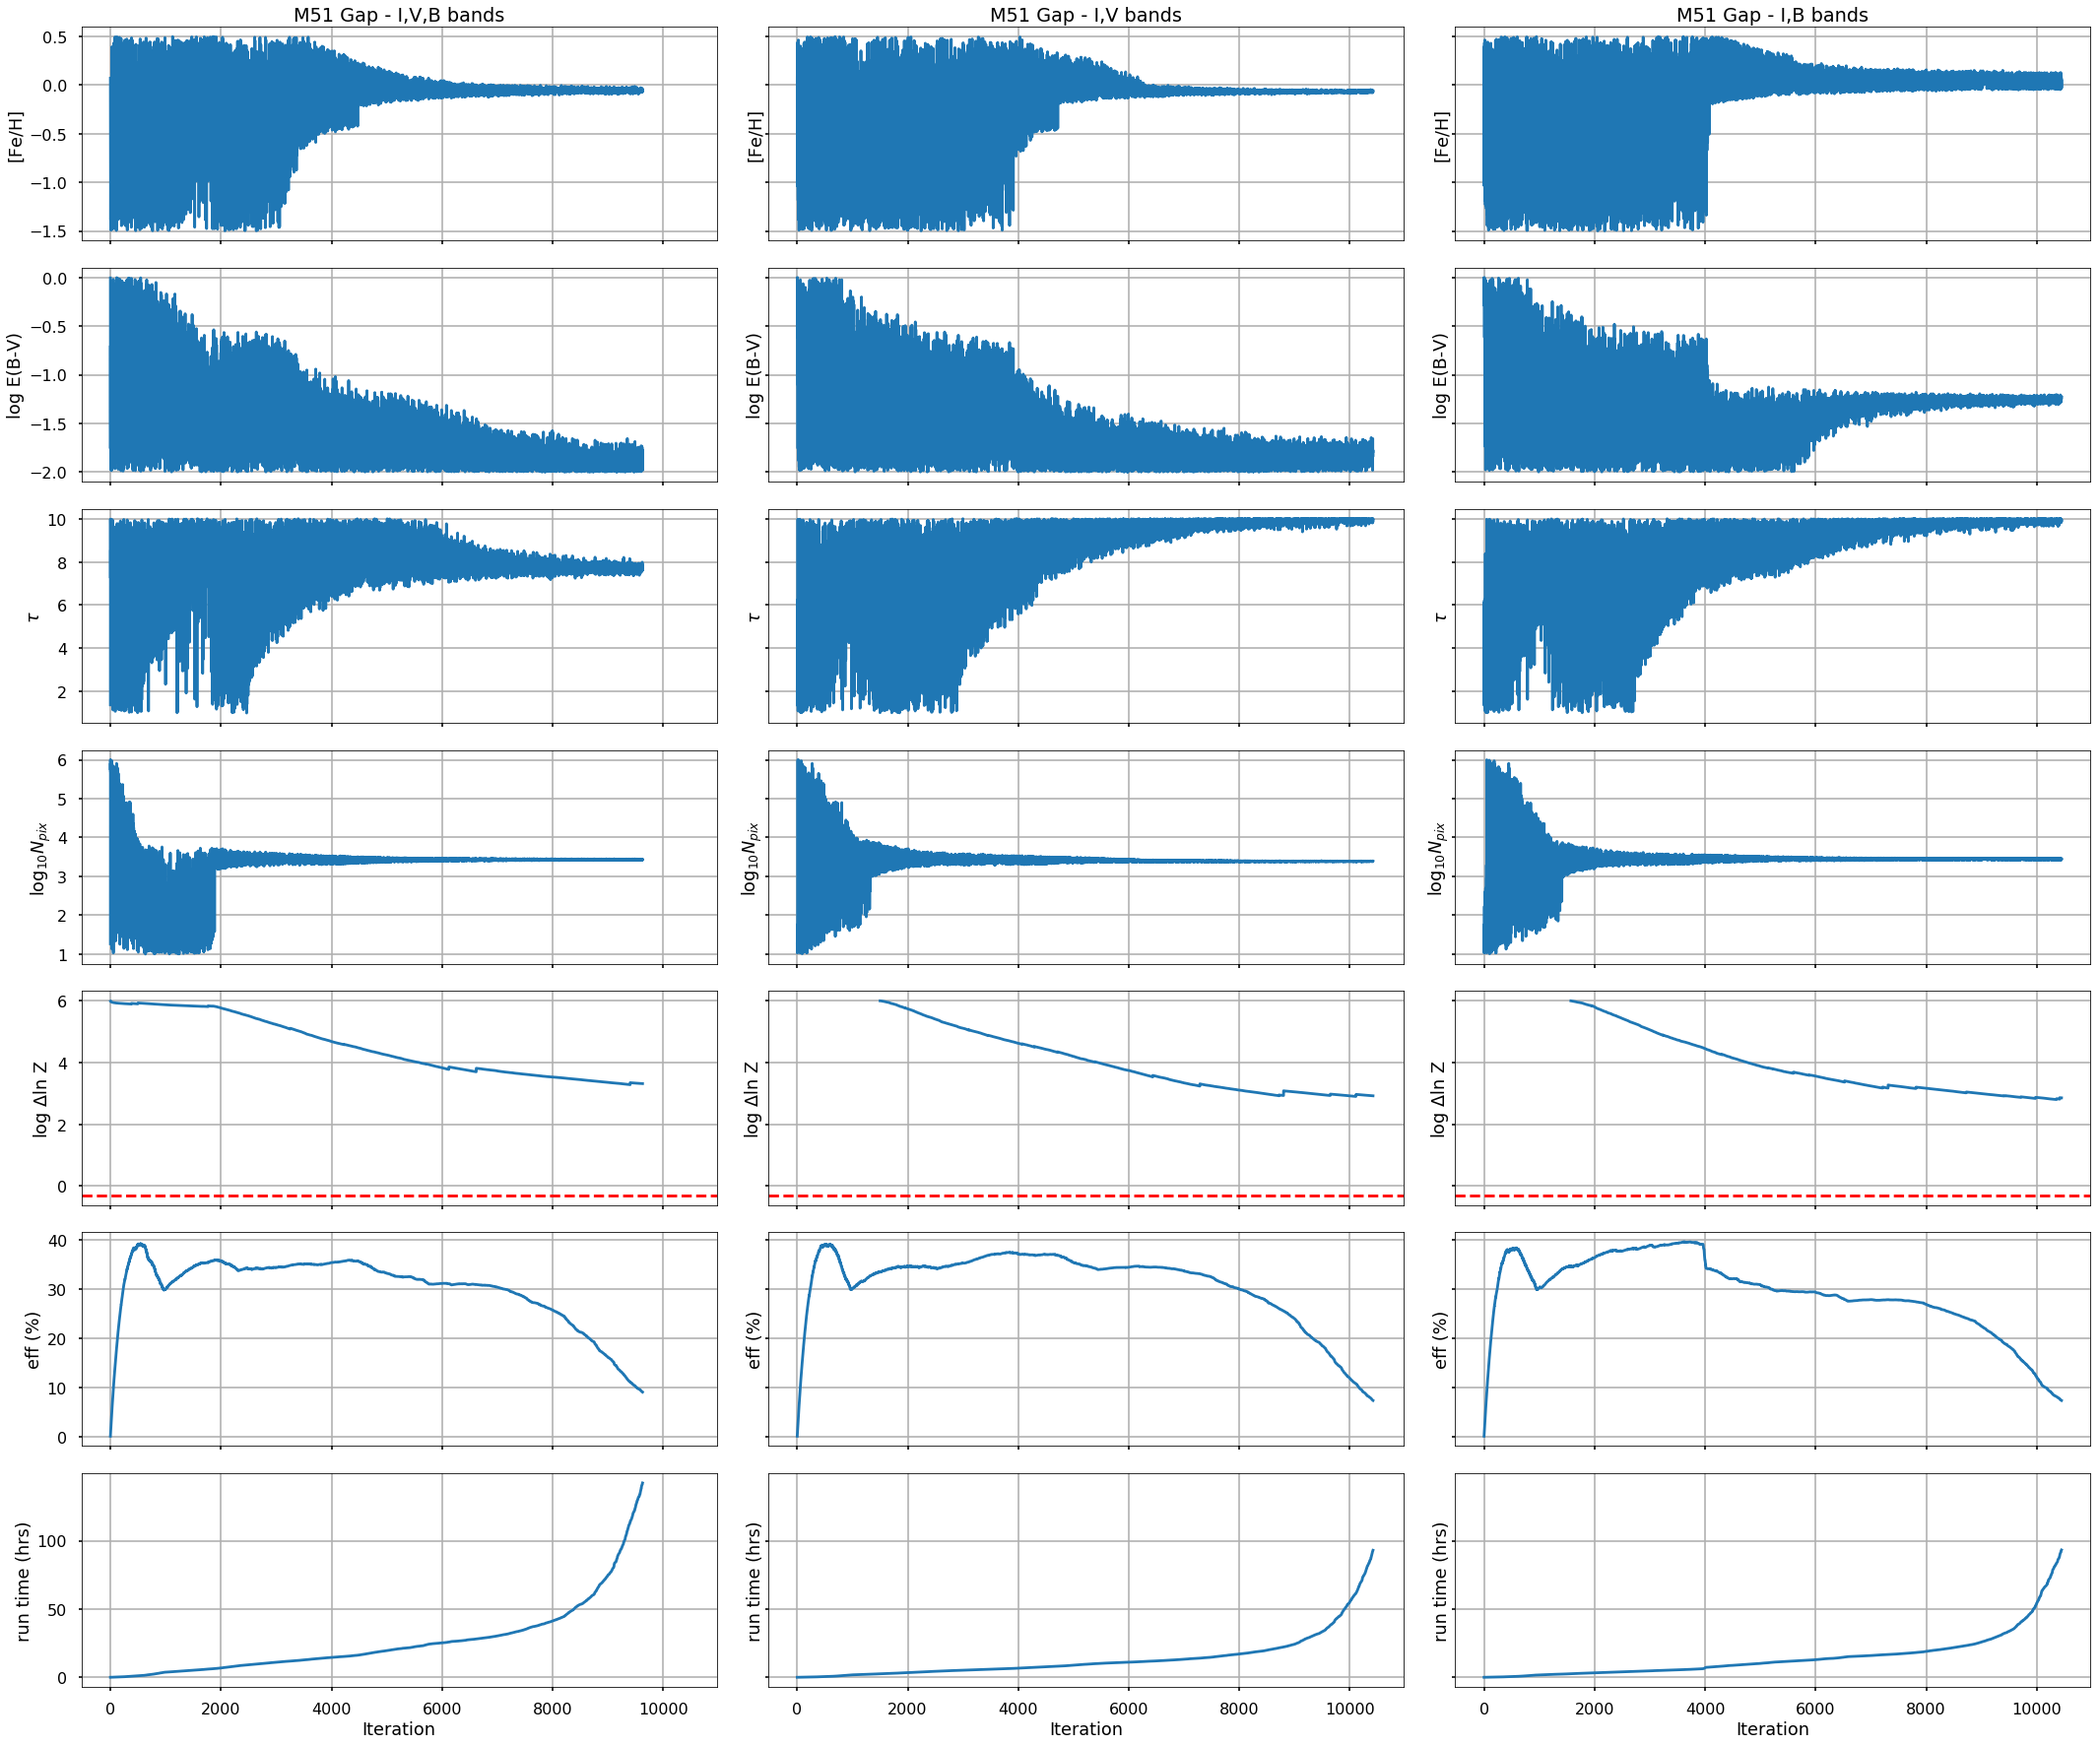

In [8]:
#### sns.set_context('poster')
fix, axes = plt.subplots(ncols=3, nrows=7, figsize=(30, 25), sharex=True, sharey='row')
results['IVB'].plot_chains(axes=axes[:,0])
results['IV'].plot_chains(axes=axes[:,1])
results['IB'].plot_chains(axes=axes[:,2])
for ax in axes.flatten():
    ax.grid(True)
plt.tight_layout()

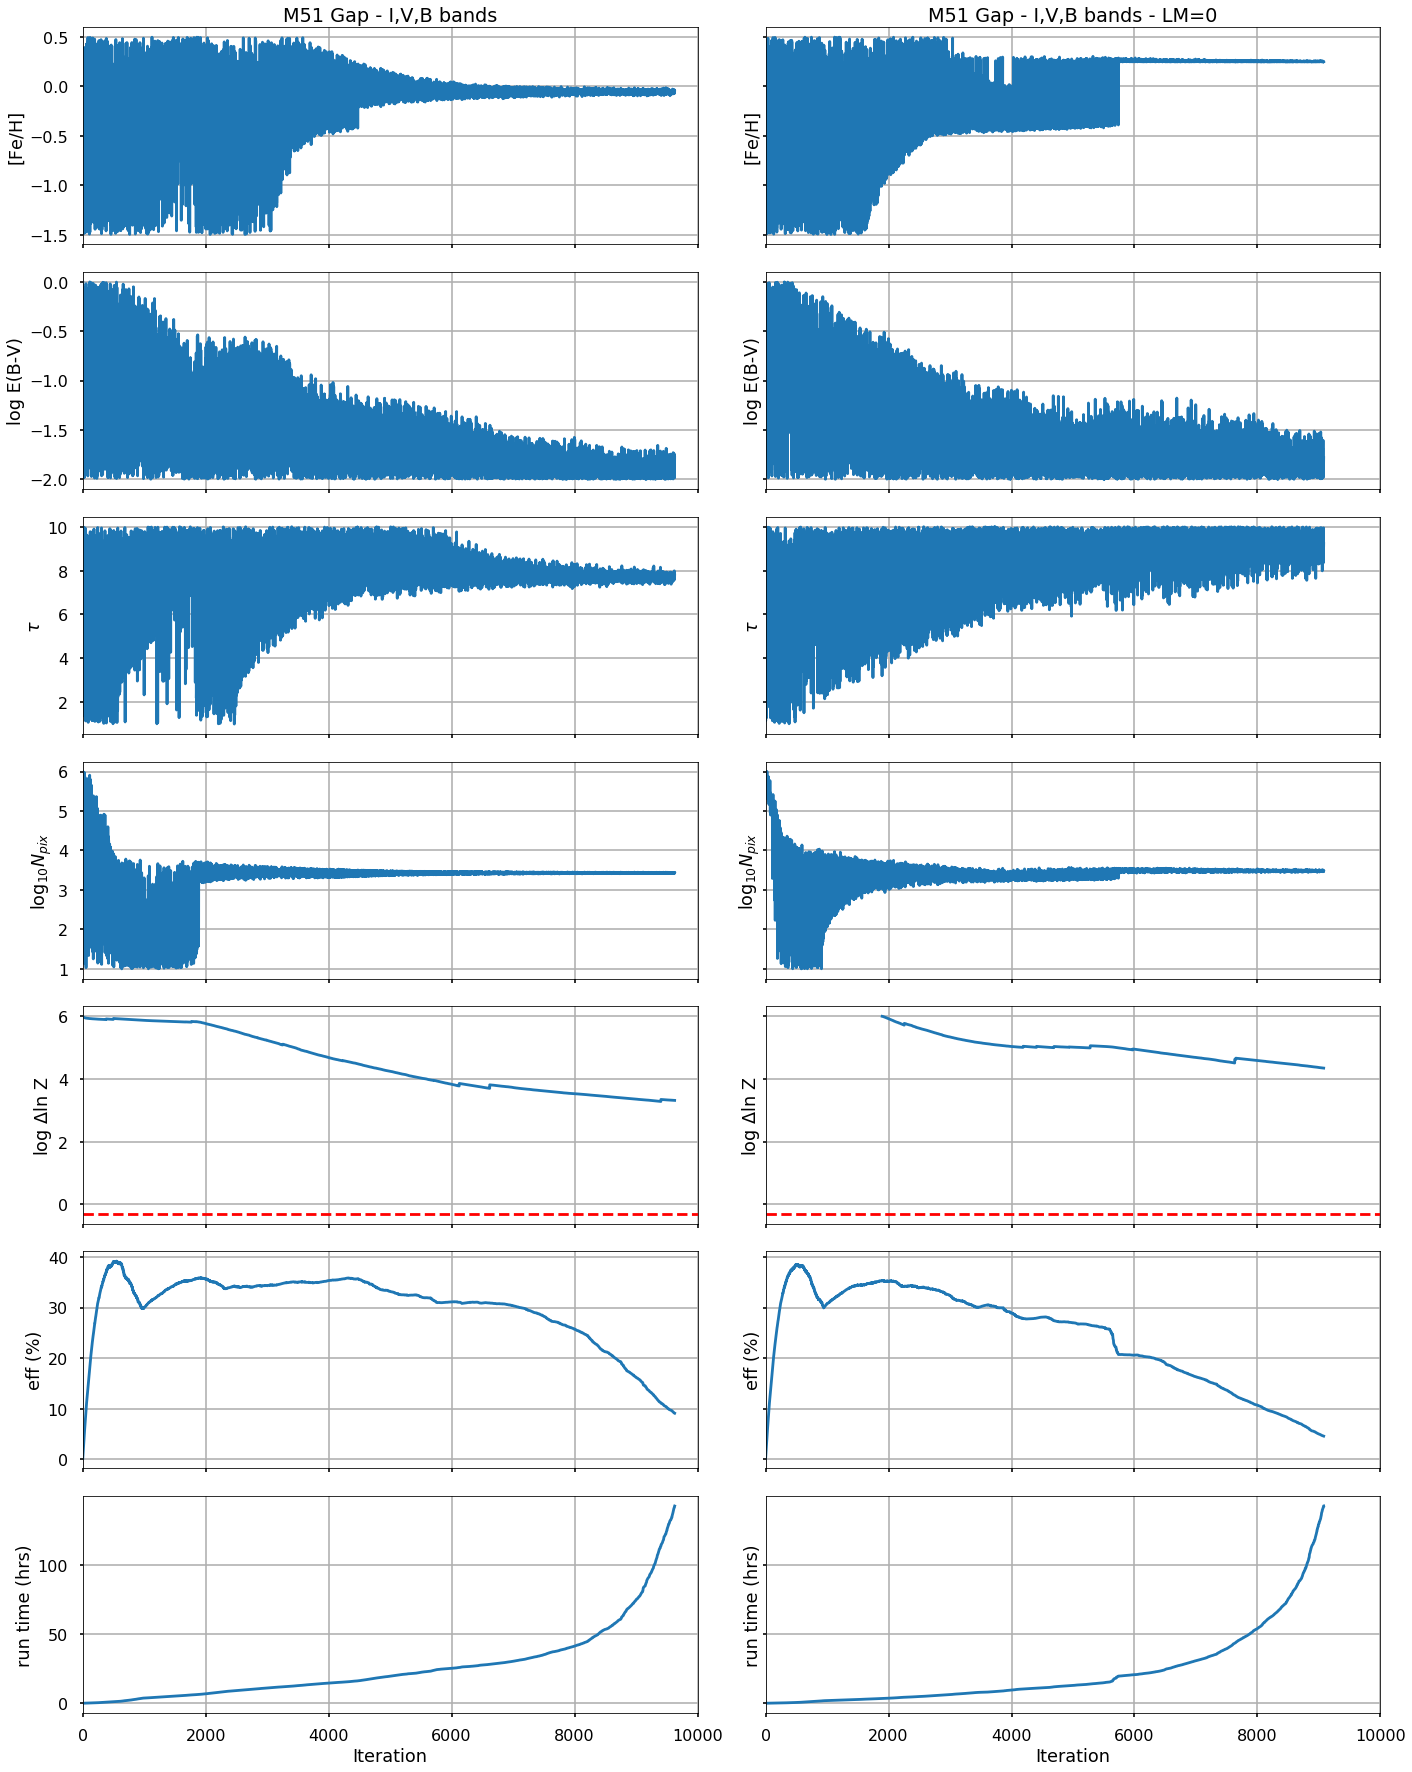

In [9]:
#### sns.set_context('poster')
fix, axes = plt.subplots(ncols=2, nrows=7, figsize=(20, 25), sharex=True, sharey='row')
results['IVB'].plot_chains(axes=axes[:,0])
results['IVB_ll0'].plot_chains(axes=axes[:,1])
axes[0,0].set_xlim([0, 10000])
for ax in axes.flatten():
    ax.grid(True)
plt.tight_layout()

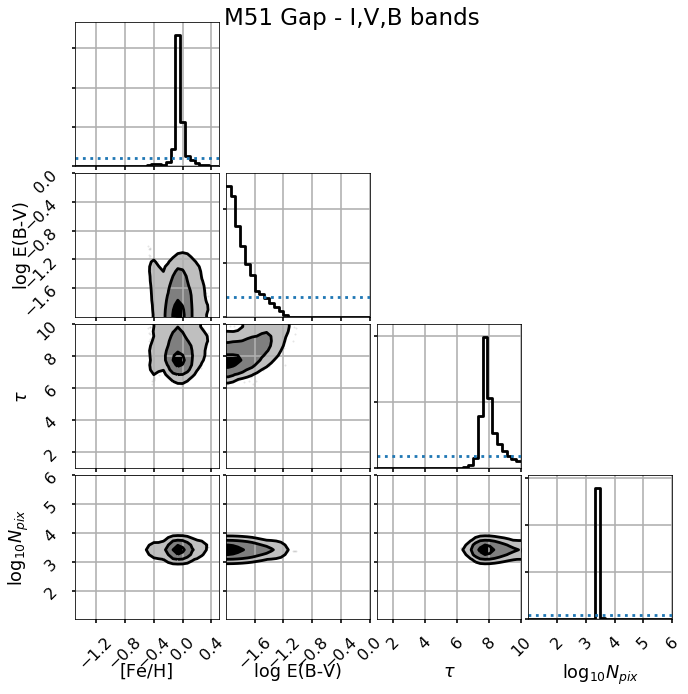

In [21]:
fig, axes = results['IVB'].plot_corner(weight=False, burn=4000, bins=30);
for ax in axes.flatten():
    ax.grid(True)

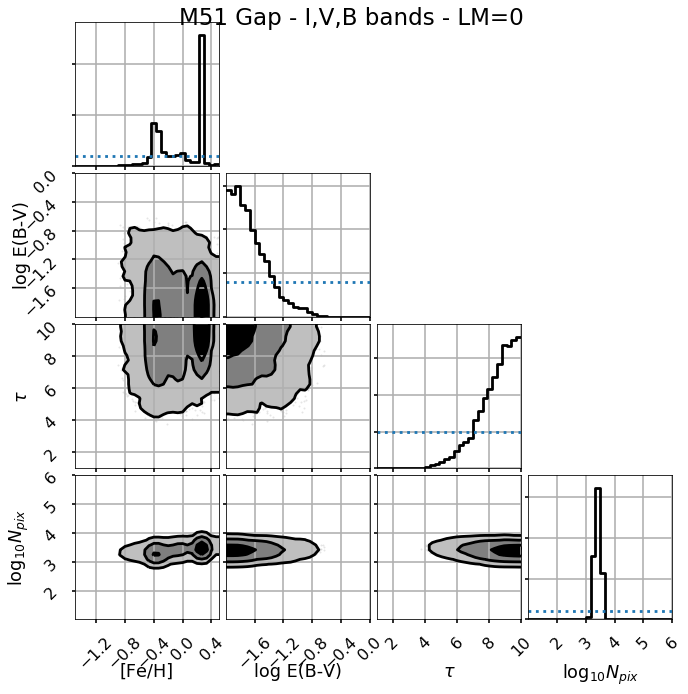

In [22]:
fig, axes = results['IVB_ll0'].plot_corner(weight=False, burn=2000, bins=30);
for ax in axes.flatten():
    ax.grid(True)

In [23]:
%%time
gal = ppy.galaxy.DefaultTau.get_model(np.array([-0.1, -2., 3.4, 7.5, dmod_m51]), iso_step=-1.)
pcmd_fit, ims_fit = driv.simulate(gal, 400, downsample=5, psf=True, shot_noise=False)

CPU times: user 48.9 s, sys: 3.74 s, total: 52.7 s
Wall time: 53 s


In [24]:
%%time
gal = ppy.galaxy.LogNormTau.get_model(np.array([-0.1, -.3, 0.5, 3.4, 7.5, dmod_m51]), iso_step=-1.)
pcmd_dust, ims_dust = driv.simulate(gal, 400, downsample=5, psf=True, shot_noise=False)

CPU times: user 57.1 s, sys: 3.75 s, total: 1min
Wall time: 1min 1s


In [25]:
%%time
gal = ppy.galaxy.DefaultTau.get_model(np.array([-0.1, -2., 3.4, 7.5, dmod_m51]), iso_step=-1.)
pcmd_shot, ims_shot = driv.simulate(gal, 400, downsample=5, psf=True, shot_noise=True)

CPU times: user 48.6 s, sys: 3.68 s, total: 52.3 s
Wall time: 52.5 s


In [26]:
%%time
gal = ppy.galaxy.MDFTau.get_model(np.array([-0.1, 0.5, -2., 3.4, 7.5, dmod_m51]), iso_step=-1.)
pcmd_mdf, ims_mdf = driv.simulate(gal, 400, downsample=5, psf=True, shot_noise=False)

CPU times: user 4min 40s, sys: 50 s, total: 5min 30s
Wall time: 5min 44s


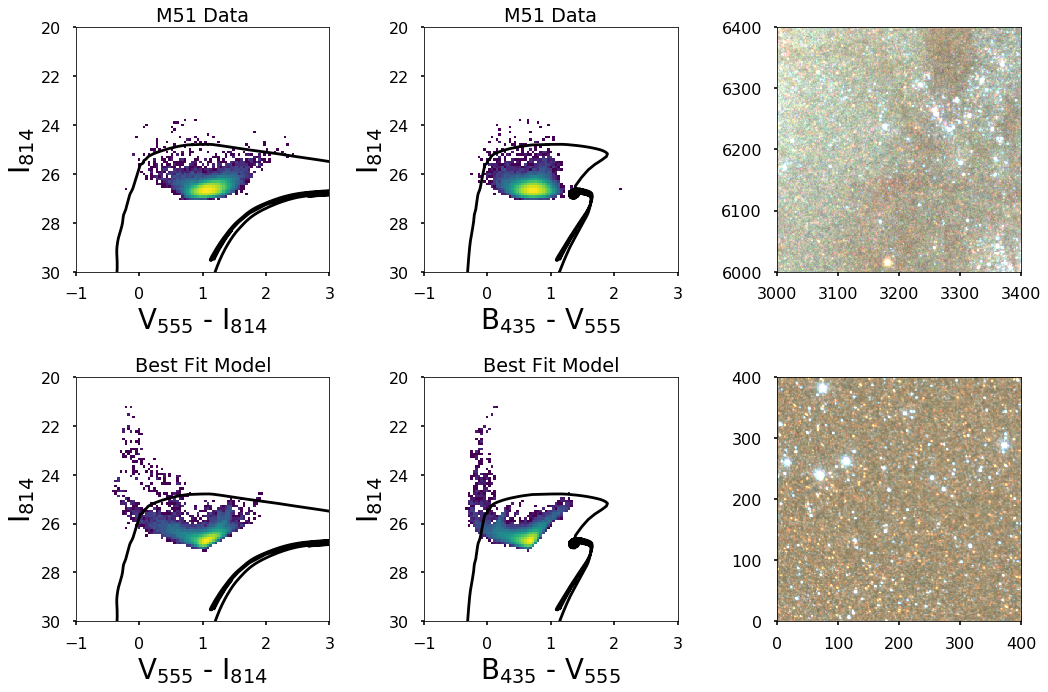

In [27]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
axes[0,0].hist2d(pcmd_data[1], pcmd_data[0], bins=bins, norm=mpl.colors.LogNorm())
axes[0,1].hist2d(pcmd_data[2], pcmd_data[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,0].hist2d(pcmd_fit[1], pcmd_fit[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,1].hist2d(pcmd_fit[2], pcmd_fit[0], bins=bins, norm=mpl.colors.LogNorm())
for a in axes[0,:2]:
    a.set_title('M51 Data')
for a in axes[1,:2]:
    a.set_title('Best Fit Model')
ppy.utils.plot_rgb_image(ims_data, extent=extent, ax=axes[0,2])
ppy.utils.plot_rgb_image(ims_fit, ax=axes[1,2])
iso_model.plot_isochrone(ssp, axes=axes[0,:2], system='vega')
iso_model.plot_isochrone(ssp, axes=axes[1,:2], system='vega')
plt.tight_layout()
# plt.savefig('figures/m51_bestfit.pdf')

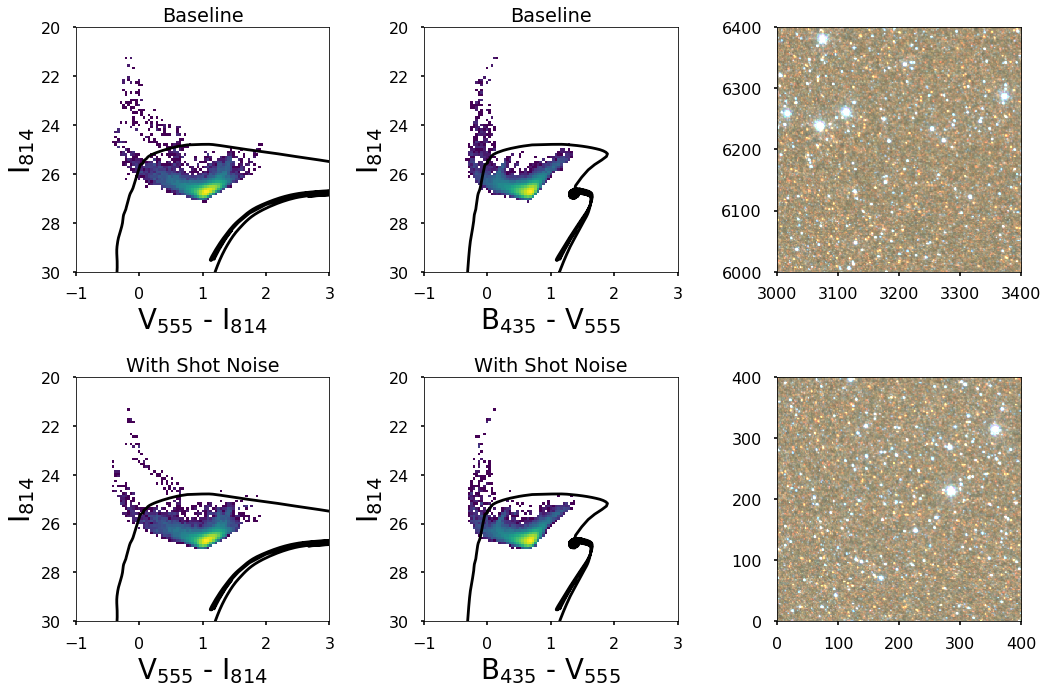

In [28]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
axes[0,0].hist2d(pcmd_fit[1], pcmd_fit[0], bins=bins, norm=mpl.colors.LogNorm())
axes[0,1].hist2d(pcmd_fit[2], pcmd_fit[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,0].hist2d(pcmd_shot[1], pcmd_shot[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,1].hist2d(pcmd_shot[2], pcmd_shot[0], bins=bins, norm=mpl.colors.LogNorm())
for a in axes[0,:2]:
    a.set_title('Baseline')
for a in axes[1,:2]:
    a.set_title('With Shot Noise')
ppy.utils.plot_rgb_image(ims_fit, extent=extent, ax=axes[0,2])
ppy.utils.plot_rgb_image(ims_shot, ax=axes[1,2])
iso_model.plot_isochrone(ssp, axes=axes[0,:2], system='vega')
iso_model.plot_isochrone(ssp, axes=axes[1,:2], system='vega')
plt.tight_layout()
# plt.savefig('figures/m51_bestfit.pdf')

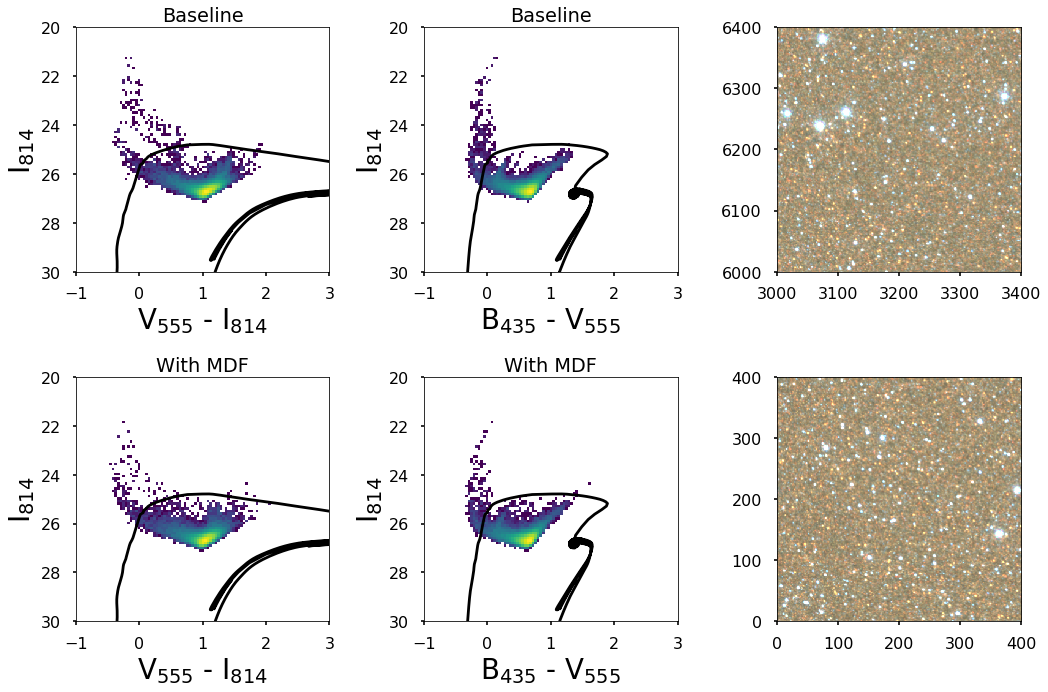

In [29]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
axes[0,0].hist2d(pcmd_fit[1], pcmd_fit[0], bins=bins, norm=mpl.colors.LogNorm())
axes[0,1].hist2d(pcmd_fit[2], pcmd_fit[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,0].hist2d(pcmd_mdf[1], pcmd_mdf[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,1].hist2d(pcmd_mdf[2], pcmd_mdf[0], bins=bins, norm=mpl.colors.LogNorm())
for a in axes[0,:2]:
    a.set_title('Baseline')
for a in axes[1,:2]:
    a.set_title('With MDF')
ppy.utils.plot_rgb_image(ims_fit, extent=extent, ax=axes[0,2])
ppy.utils.plot_rgb_image(ims_mdf, ax=axes[1,2])
iso_model.plot_isochrone(ssp, axes=axes[0,:2], system='vega')
iso_model.plot_isochrone(ssp, axes=axes[1,:2], system='vega')
plt.tight_layout()
# plt.savefig('figures/m51_bestfit.pdf')

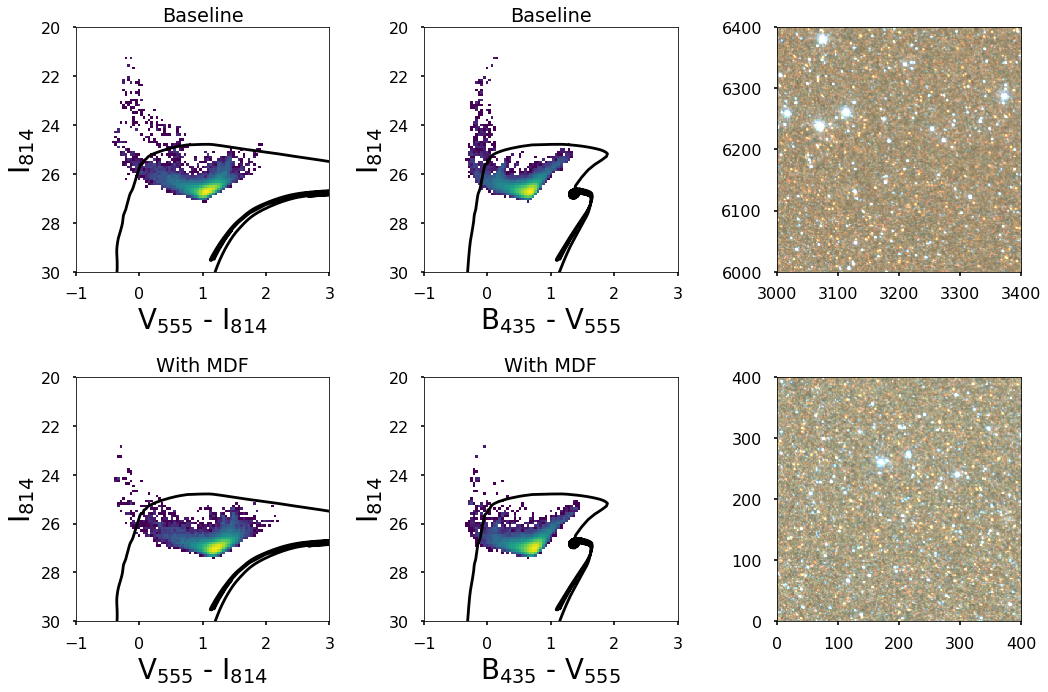

In [30]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
axes[0,0].hist2d(pcmd_fit[1], pcmd_fit[0], bins=bins, norm=mpl.colors.LogNorm())
axes[0,1].hist2d(pcmd_fit[2], pcmd_fit[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,0].hist2d(pcmd_dust[1], pcmd_dust[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,1].hist2d(pcmd_dust[2], pcmd_dust[0], bins=bins, norm=mpl.colors.LogNorm())
for a in axes[0,:2]:
    a.set_title('Baseline')
for a in axes[1,:2]:
    a.set_title('With MDF')
ppy.utils.plot_rgb_image(ims_fit, extent=extent, ax=axes[0,2])
ppy.utils.plot_rgb_image(ims_dust, ax=axes[1,2])
iso_model.plot_isochrone(ssp, axes=axes[0,:2], system='vega')
iso_model.plot_isochrone(ssp, axes=axes[1,:2], system='vega')
plt.tight_layout()
# plt.savefig('figures/m51_bestfit.pdf')